# Weight Initialization, Dead Neurons, Leaky ReLU

This notebook explores the effects of different weight initialization methods, vanishing gradients, and dead neurons. It also examines the impact of Leaky ReLU activation.

## Overview
The key steps involve experimenting with different weight initializations, analyzing vanishing gradients, and comparing the effects of ReLU and Leaky ReLU activations.

## Procedure
- **Vanishing Gradients**: Explain the phenomenon using RandomNormal initialization with different standard deviations for tanh and sigmoid activations.
- **Xavier Initialization**: Show how Xavier initialization helps in dealing with vanishing gradients.
- **Dying ReLU**: Demonstrate the dying ReLU phenomenon using a ReLU network and calculate the fraction of collapsed networks.
- **Leaky ReLU**: Implement Leaky ReLU activation and repeat the training simulations, calculating the fraction of collapsed networks and analyzing the results.

In [1]:
import inspect
import os

import tensorflow as tf

keras = tf.keras
import os
import sys

from keras import Sequential, layers, models, optimizers

sys.path.insert(0, './neural-network-initialization')
sys.path.append('./')
import warnings
warnings.filterwarnings("ignore")


In [2]:
tf.__version__
tf.config.experimental.list_physical_devices('GPU'), tf.keras.backend.floatx()


([], 'float32')

## 3.1

In [3]:
# import keras  # noqa: F401
import tensorflow as tf

keras = tf.keras
import sys

import numpy as np
import pandas as pd
import seaborn as sns
from keras import activations, initializers, layers, models, optimizers
# from keras.layers import Dense, Activation

from keras import backend as k
from keras.datasets import mnist
from matplotlib import pyplot as plt

sys.path.insert(0, "./neural-network-initialization")

from nn_inititals_mod.utils import (
    LossHistory,
    compile_model,
    create_cnn_model,
    create_mlp_model,
    get_activations,
    get_init_id,
    grid_axes_it,
)


In [4]:
if tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()


In [5]:
# set traceback mode
%xmode Verbose

pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 50)
pd.set_option("display.max_rows", 50)


Exception reporting mode: Verbose


In [6]:

def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(layers.Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(layers.Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(layers.Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model





In [7]:
keras = tf.keras
from keras.datasets import mnist
import numpy as np

seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 3
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [9]:
# %qtconsole
# y_train.resh


In [10]:

def get_initializer(sigma):
    return tf.keras.initializers.RandomNormal(mean=0., stddev=sigma)

rows = []
sigmas = [0.10, 0.14, 0.28]


def get_MLP_model(sigma, activation,initializer=None,  *args, **kwargs):
    # Initialize the model with the specified parameters
    model = create_mlp_model(
        n_hidden_layers=3,
        dim_layer=100,
        input_shape=data_dim,
        n_classes=num_classes,
        kernel_initializer=get_initializer(sigma) if initializer is None else initializer,
        bias_initializer='zeros',
        activation=activation,

    )

    return model

def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):

    model = Sequential()
    model.add(layers.Dense(dim_layer, input_shape=(input_shape,), kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(layers.Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(layers.Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model

def extract_gradients(model, x_train):
    # Placeholder for gradients
    gradients = []

    for epoch in range(epochs):
        # Use GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            predictions = model(x_train)
            # Compute the loss value for this batch.
            loss_value = tf.keras.losses.sparse_categorical_crossentropy(y_train, predictions)

        # Use the tape to compute the gradient against all parameters in model.
        grads = tape.gradient(loss_value, model.trainable_variables)
        gradients.append(grads)

    variables = tape.watched_variables()
    return gradients, variables


# alphas




In [12]:
def custom_training(model, data):
    x, y = data
    # Training
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)  # Forward pass

        loss = tf.keras.losses.SparseCategoricalCrossentropy(y, y_pred)

    trainable_vars = model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    tf.keras.optimizers.Adam().apply_gradients(zip(gradients, trainable_vars))

    with tf.GradientTape() as tape:
        y_pred = model(x, training=False)  # Forward pass

        loss = tf.keras.losses.mse(y, y_pred)
    trainable_vars = model.trainable_variables
    gradients_plus = tape.gradient(loss, trainable_vars)

    return gradients, gradients_plus


sigma = 0.14
activation = 'sigmoid'
epochs=2
model = get_MLP_model(sigma, activation)
model.summary()

y_train_in = np.argmax(y_train, axis=1)
inputs = tf.convert_to_tensor(x_train, dtype=tf.float32)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(inputs)
    out_intermediate = []
    cargo = model.layers[0](inputs)
    for layer in model.layers[1:]:
        cargo = layer(cargo)
        out_intermediate.append(cargo)

gradient_evolutions = []
for x in out_intermediate:
    gradient_evolutions.append(tape.gradient(x, inputs))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               78500     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 109810 (428.95 KB)
Trainable params: 109810 (428.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:

X, y = x_test, y_test

N = 10000
X, y = X[:N], y[:N]


model = get_MLP_model(sigma, activation)
with tf.GradientTape() as tape:
    output = model(X)
    loss = keras.losses.categorical_crossentropy(output, y)

grads = tape.gradient(loss, model.trainable_variables)

gradients_store = []
bias_store = []

for var, g in zip(model.trainable_variables, grads):
    # print(f'{var.name}, shape: {g.shape}')

    if 'kernel' in var.name:
        gradients_store.append([var.name, g])
    else:
        bias_store.append([var.name, g])


names = [g[0] for g in gradients_store]
gradients = [g[1].numpy().flatten() for g in gradients_store]




### Gradient evolution with Standard Normal and Tanh and Sigmoid activations for various sigmas


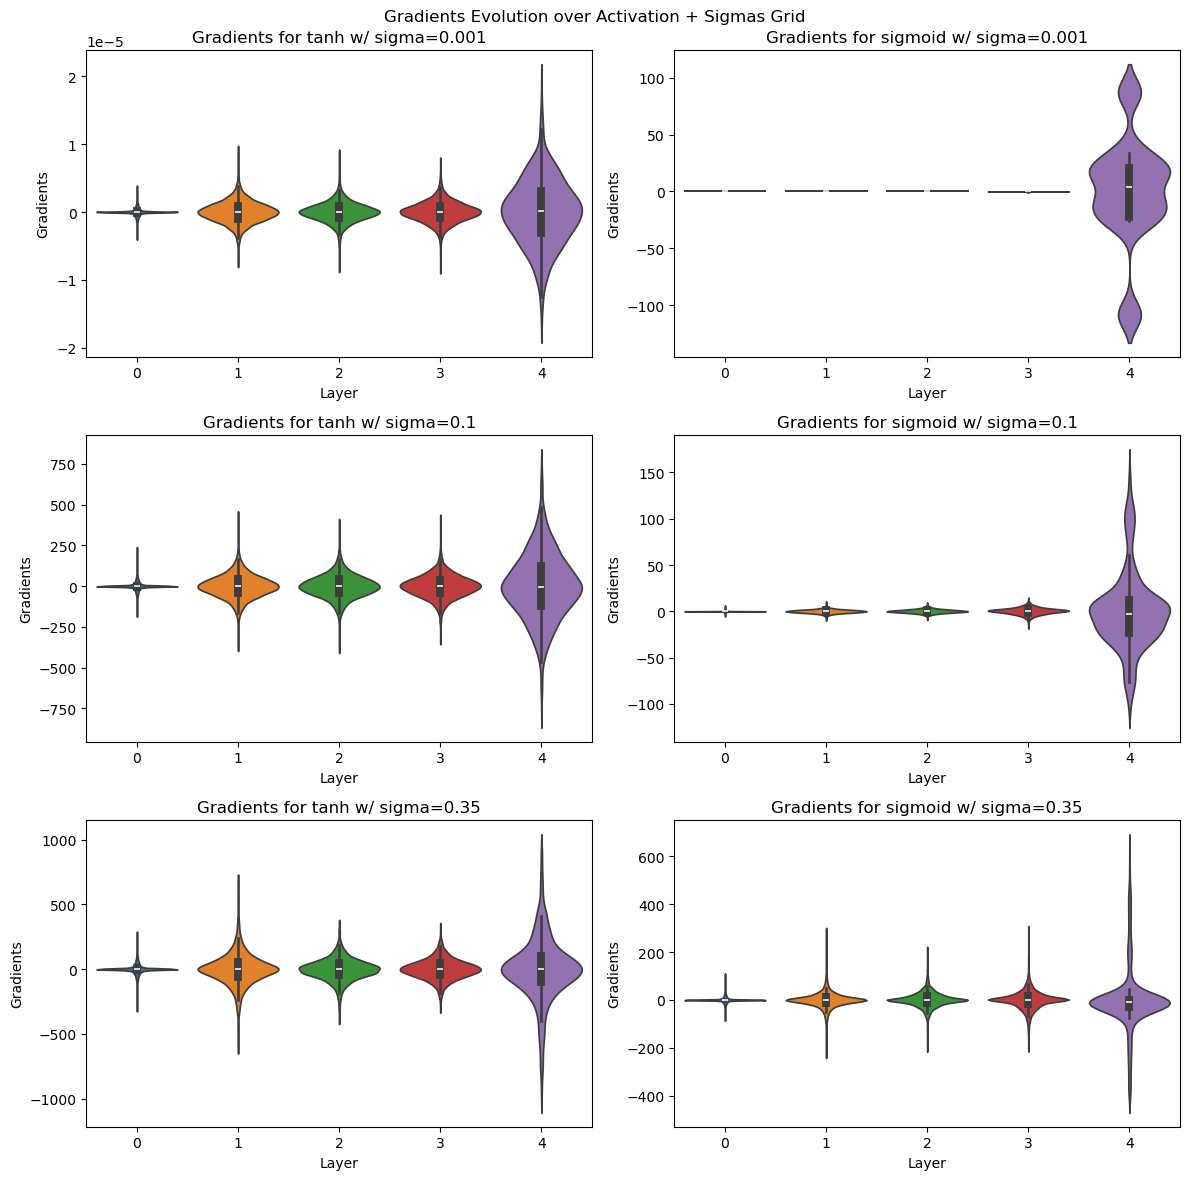

In [15]:
import tensorflow as tf
from tensorflow import keras

def extract_gradients(sigma, activation, model=None):

    model = get_MLP_model(sigma, activation) if model is None else model

    X, y = x_test[:10000], y_test[:10000]

    with tf.GradientTape() as tape:
        output = model(X)
        loss = keras.losses.categorical_crossentropy(output, y)

    grads = tape.gradient(loss, model.trainable_variables)

    gradients_store = []
    bias_store = []

    for var, g in zip(model.trainable_variables, grads):
        if 'kernel' in var.name:
            gradients_store.append([var.name, g])
        else:
            bias_store.append([var.name, g])

    names = [g[0] for g in gradients_store]
    gradients = [g[1].numpy().flatten() for g in gradients_store]

    return names, gradients


sigmas = [0.001, 0.10, 0.35]


fig = plt.figure(figsize=(12, 12))
for idx, sigma in enumerate(sigmas):
    layernames, gradients = extract_gradients(sigma, 'tanh')
    # only in first column
    plt.subplot(3, 2, idx*2+1)
    sns.violinplot(data=gradients)
    plt.title(f'Gradients for tanh w/ sigma={sigma}')
    plt.xlabel('Layer')
    plt.ylabel('Gradients')




for idx, sigma in enumerate(sigmas):
    layernames, gradients = extract_gradients(sigma, 'sigmoid')
    plt.subplot(3, 2, (idx+1)*2)
    sns.violinplot(data=gradients)
    plt.title(f'Gradients for sigmoid w/ sigma={sigma}')
    plt.xlabel('Layer')
    plt.ylabel('Gradients')

plt.suptitle('Gradients Evolution over Activation + Sigmas Grid')
plt.tight_layout()

plt.show()



In [24]:
for idx, sigma in enumerate(sigmas):
    layernames, gradients = extract_gradients(sigma, 'tanh')
    # print name, mean gradients, variance gradients
    means = [np.mean(g) for g in gradients]
    stds = [np.std(g) for g in gradients]

    print(f'Sigma={sigma}, activation=tanh, avg_grad={np.mean(means)}, std_grad={np.std(stds)} gradient_mean={means}, gradient_std={stds}')

print()
for idx, sigma in enumerate(sigmas):
    layernames, gradients = extract_gradients(sigma, 'sigmoid')
    means = [np.mean(g) for g in gradients]
    stds = [np.std(g) for g in gradients]

    print(f'Sigma={sigma}, activation=sigmoid, avg_grad={np.mean(means)}, std_grad={np.std(stds)} gradient_mean={means}, gradient_std={stds}')


Sigma=0.001, activation=tanh, avg_grad=8.345059754333306e-09, std_grad=1.756856818246888e-06 gradient_mean=[8.918008e-09, -1.9532904e-09, 3.3229022e-09, 3.1436734e-08, 9.458745e-13], gradient_std=[6.649311e-07, 1.9668455e-06, 1.919268e-06, 1.9094232e-06, 5.832201e-06]
Sigma=0.1, activation=tanh, avg_grad=-0.15786248445510864, std_grad=62.32695388793945 gradient_mean=[0.024037007, 0.12712601, -0.91631526, -0.024161182, 9.765625e-07], gradient_std=[30.206377, 80.935265, 79.6405, 71.914246, 214.41205]
Sigma=0.35, activation=tanh, avg_grad=0.35252466797828674, std_grad=69.3686752319336 gradient_mean=[1.1620762, 0.8086966, -0.14867927, -0.059471656, 1.2817383e-06], gradient_std=[48.14925, 126.45499, 91.781624, 84.674255, 249.6603]

Sigma=0.001, activation=sigmoid, avg_grad=0.0003194464952684939, std_grad=19.08635902404785 gradient_mean=[-2.7645522e-10, 2.8525035e-10, -1.4002239e-05, 0.001134405, 0.00047682953], gradient_std=[9.9638005e-09, 2.798114e-08, 0.00010235853, 0.0412023, 47.72621]
S

For tanh with sigma=0.001, gradients are near zero, indicating vanishing gradients. Increasing sigma to 0.1 and 0.35, gradients' distribution is more uniform but explodes in the lasat layer indicating instability. For sigmoid with sigma=0.001, gradients are also near zero. With sigma=0.1, gradients improve slightly but are still small. At sigma=0.35, gradients' mean and std increase, suggesting less vanishing but potential for exploding gradients. Overall, tanh is more stable to variable std of Standard Normal initialization than sigmoid.


## 3.2


1
3
5


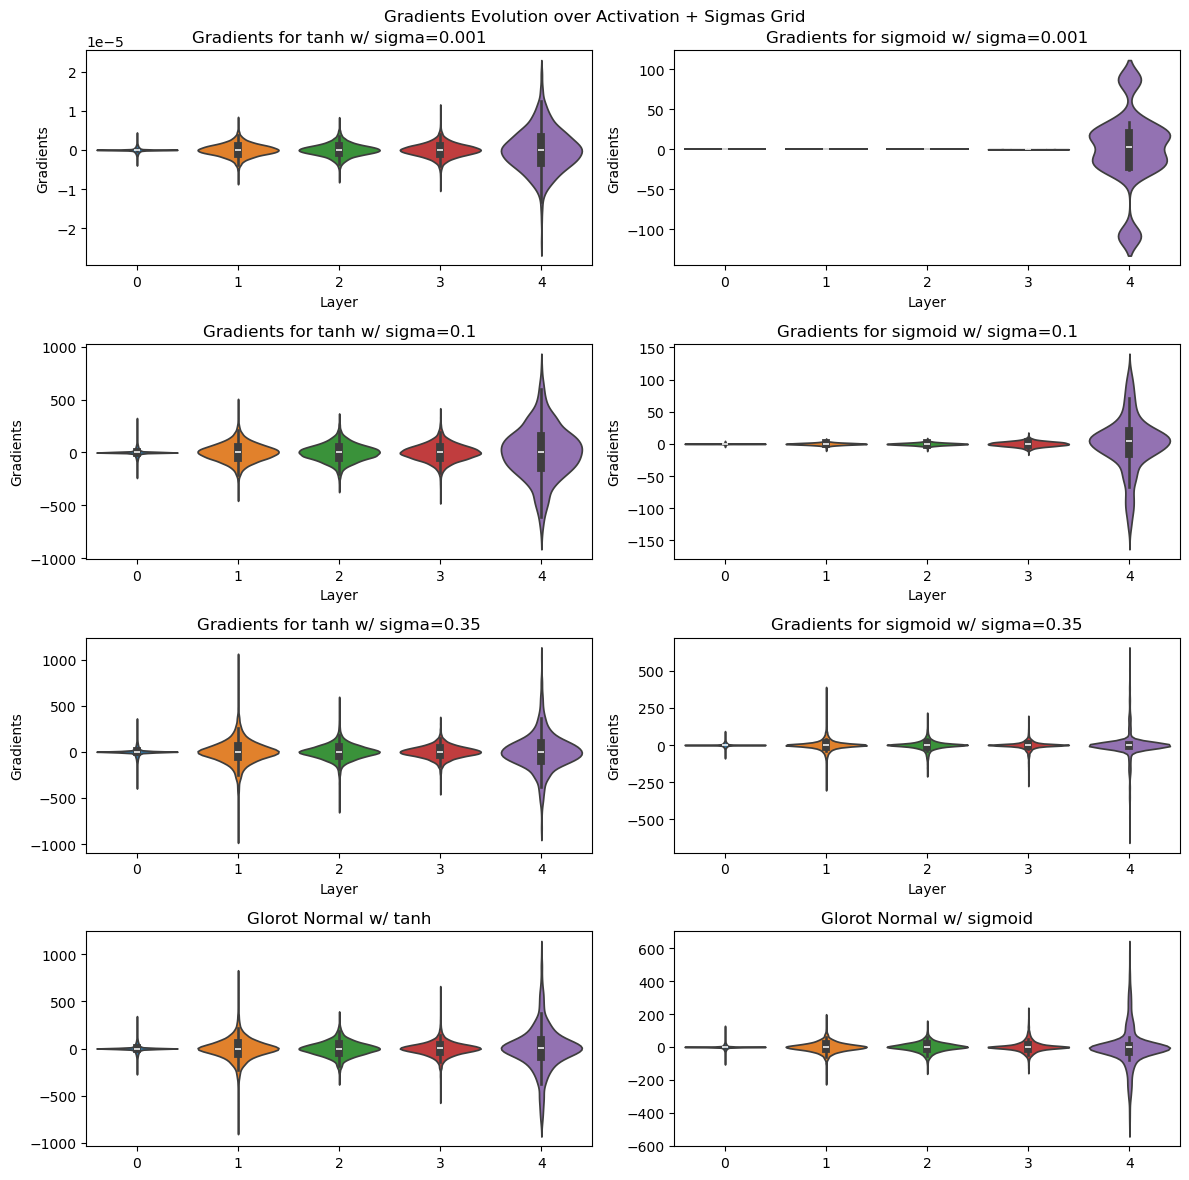

In [16]:
get_MLP_model

sigmas = [0.001, 0.10, 0.35]


fig = plt.figure(figsize=(12, 12))

for idx, sigma in enumerate(sigmas):
    layernames, gradients = extract_gradients(sigma, 'tanh')
    print(2*idx+1)
    # only in first column
    plt.subplot(4, 2,  idx*2+1)
    sns.violinplot(data=gradients)
    plt.title(f'Gradients for tanh w/ sigma={sigma}')
    plt.xlabel('Layer')
    plt.ylabel('Gradients')






for idx, sigma in enumerate(sigmas):
    # print(2*idx+2)
    layernames, gradients = extract_gradients(sigma, 'sigmoid')
    plt.subplot(4, 2, (idx+1)*2)
    sns.violinplot(data=gradients)
    plt.title(f'Gradients for sigmoid w/ sigma={sigma}')
    plt.xlabel('Layer')
    plt.ylabel('Gradients')


plt.subplot(4, 2, 7)
model = get_MLP_model(sigma, 'tanh', initializer=keras.initializers.GlorotNormal(),)
layernames, gradients = extract_gradients(sigma, 'tanh')
sns.violinplot(data=gradients)
plt.title('Glorot Normal w/ tanh')



plt.subplot(4, 2, 8)
model = get_MLP_model(sigma, 'sigmoid', initializer=keras.initializers.GlorotNormal(),)
layernames, gradients = extract_gradients(sigma, 'sigmoid')
sns.violinplot(data=gradients)
plt.title('Glorot Normal w/ sigmoid')


plt.suptitle('Gradients Evolution over Activation + Sigmas Grid')
plt.tight_layout()

plt.show()


We can see in the figure above that for models with tanh activation, Glorot initialization resulted in quiet similar gradient distributions to that of Random Normal initialization. However, for models with ReLU activation, Glorot initialization resulted in a more uniform distribution of gradients, but still displays signs of exploding gradients.

## 3.3


In [ ]:
import tensorflow as tf
import numpy as np



def f(x):
    return abs(x)

def train():a
        x_train = np.random.uniform(-np.sqrt(7), np.sqrt(7), size=(3000, 1))
        y_train = x_train * np.sin(5 * x_train)

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(1,)))
        for _ in range(10):
            model.add(tf.keras.layers.Dense(2, activation='relu'))
        model.add(tf.keras.layers.Dense(1))  # Output layer

        model.compile(optimizer='adam', loss='mse')
        model.fit(x_train, y_train, batch_size=64, epochs=1, verbose=0)
        model.weights
        y_pred = model.predict(x_train)
        return y_pred



def run_simulations(n_simulations=1000):
    collapse = 0

    results = []
    for _ in range(n_simulations):
        y_pred = train()
        if np.var(y_pred) == 0:
            collapse += 1


    return collapse / n_simulations, results




with tf.device('/CPU:0'):
    results = run_simulations(1000)

    variances = np.array([np.var(result) for result in results])
    if any(np.isnan(variances)):
        variances[np.isnan(variances)] = 0


94/94 [==============================] - 0s 566us/step


In [ ]:
import rich
rich.print(f"{results[0]*100}% resulted in Collapse")


28.000000000000004% resulted in Collapse

In the results above with regular ReLU activation, the network collapsed 28.0% of the time. This is less than what was reported in `Lu et al`.


### Percentage Collapse


## 3.4


### Leaky ReLU Implementation


In [ ]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import initializers
from keras.layers import LeakyReLU


def f(x):
    return abs(x)

def train():
        x_train = np.random.uniform(-np.sqrt(7), np.sqrt(7), size=(3000, 1))
        y_train = x_train * np.sin(5 * x_train)

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(1,)))
        for _ in range(10):
            model.add(tf.keras.layers.Dense(2))
            model.add(LeakyReLU())
        model.add(tf.keras.layers.Dense(1))


        model.compile(optimizer='adam', loss='mse')
        model.fit(x_train, y_train, batch_size=64, epochs=1, verbose=0)
        model.weights
        y_pred = model.predict(x_train)
        return y_pred



def run_simulations(n_simulations=1000):
    collapse = 0

    results = []
    for _ in range(n_simulations):
        y_pred = train()
        if np.var(y_pred) == 0:
            collapse += 1


    return collapse / n_simulations, results


with tf.device('/CPU:0'):
    results = run_simulations(100)
    variances = np.array([np.var(result) for result in results])
    if any(np.isnan(variances)):
        variances[np.isnan(variances)] = 0


94/94 [==============================] - 0s 562us/step


In [ ]:
results


(0.0, [])

From the results above, we can see that none of the networks collapsed using leaky ReLu. I think this helps because leaky ReLu allows for a small gradient when the unit is not active, which prevents the dying ReLu problem.